# 20201118 - RNA fold changes of NMD targets in EJC factor knockdowns
### with counts from salmon mapping and fold changes by DESeq2

In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
def log_trans(x):
    try:
        return math.log(x, 10)
    except:
        return float('NaN')

Import Colombo et al. NMD targets (my own computations)

In [3]:
import pandas as pd
import pandas as pd

colombo_p_values = pd.read_csv('../../8.019_profiling_analysis/4_20200809_NMD_target_calls/20200809_all_tx_colombo_NMD_meta_pvalues.tsv', sep = '\t')
colombo_p_values.sort_values(by=['meta_meta'], inplace=True)

Import and combine xtail analysis results

In [4]:
#import and concatenate data
import pandas as pd
import numpy as np
import math
import os
columns = ['tx_id','baseMean','mRNA_log2FC','lfcSE','stat','pvalue','padj', 'dataset']
all_deseq = []

for file_name in os.listdir('../1_deseq/DESeq_results/'):
    if file_name.endswith('txt') and not file_name.startswith('.'):
        sample_name = file_name[:-4]
        df = pd.read_csv(os.path.join('../1_deseq/DESeq_results/', file_name), sep='\t')
        df['dataset'] = sample_name
        df.columns = columns
        all_deseq.append(df)

combined_deseq_results = pd.concat(all_deseq, sort=False)

Plot mRNA fold changes

In [5]:
#set up plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
plt.rcParams['pdf.fonttype'] = 42 #leaves most text as actual text in PDFs, not outlines
# Say, "the default sans-serif font is arial"
mpl.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
mpl.rcParams['font.family'] = "sans-serif"
##plot CDF or mRNA RPKMs
black = (0,0,0)
gray = (0.5,0.5,0.5)
orange = (230/255.0,159/255.0,0)
skyBlue = (86/255.0,180/255.0,233/255.0)
bluishGreen = (0,158/255.0,115/255.0)
yellow = (240/255.0,228/255.0,66/255.0)
blue = (0,114/255.0,178/255.0)
vermillion = (213/255.0,94/255.0,0)
reddishPurple = (204/255.0,121/255.0,167/255.0)
colors = [blue, orange, bluishGreen, black, skyBlue, vermillion, reddishPurple, yellow]
rainbow = [black, vermillion, orange, bluishGreen, blue, reddishPurple, 'violet']

In [6]:
import sys
pipeline_dir = '/home/boris/analysis_pipelines/ribo_seq/'
if pipeline_dir not in sys.path:
    sys.path.append(pipeline_dir)
import ribo_utils

In [7]:
comprehensive_gtf_data = ribo_utils.gtf_data('../../8.019_profiling_analysis/20200715_orfquant/orfquant_tx_sets/superset_stops_collapsed.gtf', add_3_for_stop=True)

In [8]:
"""
GENCODE's definition of nonsense_mediated_decay
If the coding sequence (following the appropriate reference) of a transcript finishes >50bp
from a downstream splice site then it is tagged as NMD. If the variant does not cover the 
full reference coding sequence then it is annotated as NMD if NMD is unavoidable 
i.e. no matter what the exon structure of the missing portion is the transcript will be subject to NMD.
"""
def get_nmd_status_any(x):
    if '|' in x:
        return any([get_nmd_status_any(tx) for tx in x.split('|')])
    return sorted(comprehensive_gtf_data.transcript_to_entries[x])[0].get_value('transcript_type') == 'nonsense_mediated_decay'

def get_nmd_status_all(x):
    if '|' in x:
        return all([get_nmd_status_all(tx) for tx in x.split('|')])
    return sorted(comprehensive_gtf_data.transcript_to_entries[x])[0].get_value('transcript_type') == 'nonsense_mediated_decay'

def get_gene_id(x):
    if '|' in x:
        return get_gene_id(x.split('|')[0])
    return comprehensive_gtf_data.tx_to_genes[x]

def get_gene_name(x):
    if '|' in x:
        return get_gene_name(x.split('|')[0])
    return comprehensive_gtf_data.tx_to_gene_names[x]

def log_trans(x):
    try:
        return math.log(x, 10)
    except:
        return float('NaN')

combined_deseq_results['has dEJC'] = combined_deseq_results['tx_id'].apply(get_nmd_status_any)
combined_deseq_results['gene id'] = combined_deseq_results['tx_id'].apply(get_gene_id)
combined_deseq_results['gene name'] = combined_deseq_results['tx_id'].apply(get_gene_name)

#combined_xtail_results['all have dEJC'] = combined_xtail_results['tx_id'].apply(get_nmd_status_all)

In [9]:
combined_deseq_results['minus logp'] = combined_deseq_results['padj'].apply(log_trans)*-1

In [10]:
combined_deseq_results.replace([np.inf, -np.inf], np.nan)
combined_deseq_results=combined_deseq_results.dropna()

In [11]:
dataset_group = combined_deseq_results.groupby('dataset')
for dataset in combined_deseq_results['dataset'].unique():
    df = dataset_group.get_group(dataset)
    df_in_columbo = df[df['tx_id'].isin(colombo_p_values['tx_id'])]
    print(dataset, len(df), len(df_in_columbo))
    df.to_csv('%s.tsv' % (dataset), sep='\t')
#df_in_columbo

('K562_MAGOH', 16798, 13875)
('HEPG2_EIF4A3', 18209, 14379)
('K562_EIF4A3', 19706, 14721)
('HEPG2_MAGOH', 18471, 14498)


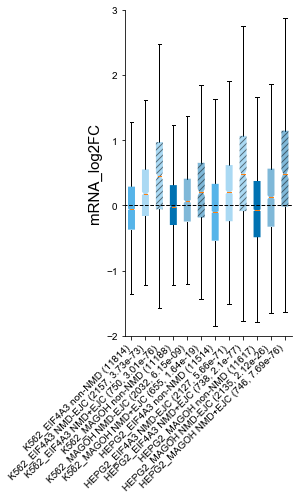

In [14]:
#plot fold changes for each dataset in same plot, single EJC cutoff, groups do not overlap
variables_to_plot = ['mRNA_log2FC']
p = .05
datasets = ['K562_EIF4A3', 'HEPG2_EIF4A3', 'HEPG2_MAGOH', 'K562_MAGOH']
#collect transcripts common to all datasets
dataset_group = combined_deseq_results.groupby('dataset')
dataset = datasets[0]
df = dataset_group.get_group(dataset)
tx_overlap = set(df.dropna()['tx_id'])
for dataset in datasets:
    df = dataset_group.get_group(dataset)
    tx_overlap = tx_overlap.intersection(set(df.dropna()['tx_id']))

plot_colors = [skyBlue, blue, reddishPurple, vermillion]


plot_index = 1
num_plots_wide = len(variables_to_plot)
num_plots_high = 1
fig = plt.figure(figsize=(3*num_plots_wide, 6*num_plots_high))

colombo_nmd_targets = colombo_p_values[colombo_p_values['meta_meta']<p]
plots = []
for variable_to_plot in variables_to_plot:
    color_index = 0
    plot = fig.add_subplot(num_plots_high, num_plots_wide, plot_index)
    plots.append(plot)
    box_data = []
    box_colors = []
    box_labels = []
    reporter_data = []
    for dataset in ['K562_EIF4A3', 'K562_MAGOH','HEPG2_EIF4A3', 'HEPG2_MAGOH']:  
        
        #first assemble dataframes for 3 groups: non-NMD targets, colombo NMD targets, colombo NMD targets with EJC
        df = dataset_group.get_group(dataset)
        #df = df[df['tx_id'].isin(tx_overlap)] #only use transcripts with data in all datasets
        all_colombo_tx = colombo_p_values[colombo_p_values['meta_meta']<=1]
        all_df = df[df['tx_id'].isin(all_colombo_tx['tx_id'])]
        #filter for NMD hits by p value
        nmd_colombo_tx = colombo_p_values[colombo_p_values['meta_meta']<=p]
        nmd_df = all_df[all_df['tx_id'].isin(nmd_colombo_tx['tx_id'])]
        #filter for colombo targets with EJC
        ejc_tx = colombo_p_values[colombo_p_values['GENCODE nmd annotation']]
        nmd_EJC_df = nmd_df[nmd_df['tx_id'].isin(ejc_tx['tx_id'])]
        #remove NMD targets from "All":
        non_nmd_df = all_df[~all_df['tx_id'].isin(nmd_df['tx_id'])]
        #remove tx with EJC from non-EJC NMD df
        no_ejc_nmd_df = nmd_df[~nmd_df['tx_id'].isin(nmd_EJC_df['tx_id'])]
        
        #append boxplot data and p values to lists
        box_data.append(non_nmd_df[variable_to_plot])
        box_colors.append(plot_colors[color_index%2])
        box_labels.append('%s non-NMD (%d)' %(dataset, len(non_nmd_df[variable_to_plot].dropna())))
                
        mwu, mwp = stats.mannwhitneyu(non_nmd_df[variable_to_plot].dropna(), no_ejc_nmd_df[variable_to_plot].dropna(), alternative='two-sided')
        box_data.append(no_ejc_nmd_df[variable_to_plot].dropna())
        box_colors.append(plot_colors[color_index%2])
        box_labels.append('%s NMD-EJC (%d, %.3g)' %(dataset, len(no_ejc_nmd_df[variable_to_plot].dropna()), mwp))
        
        mwu, mwp = stats.mannwhitneyu(non_nmd_df[variable_to_plot].dropna(), nmd_EJC_df[variable_to_plot].dropna(), alternative='two-sided')
        box_data.append(nmd_EJC_df[variable_to_plot].dropna())
        box_colors.append(plot_colors[color_index%2])
        box_labels.append('%s NMD+EJC (%d, %.3g)' %(dataset, len(nmd_EJC_df[variable_to_plot].dropna()), mwp))
        color_index+=1
        
    bp = plot.boxplot(box_data, labels=box_labels, patch_artist=True, showfliers=False, notch=True,)
    
    # fill with colors
    i = 0
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set(linewidth=0)
        if i%3 > 0:
            patch.set_alpha(0.5)
        if i%3 == 2:
            patch.set_hatch('////')
        i += 1
    #draw line at median
    for i in range(0,3*len(datasets), 3):
        mean = np.median(box_data[i])
        #plot.hlines(mean, i+0.75, i+3.25, linestyles='dashed', colors=black, linewidth=1, zorder=10)
    plot.hlines(0, 0, 3*len(datasets)+1, linestyles='dashed', colors=black, linewidth=1, zorder=10)
    #plot.set_xlabel(variable_to_plot)
    plot.set_ylabel(variable_to_plot, fontsize=15)
    #plot.set_title('NMD p = %.3g' %(p))
    #plot.set_ylim(0, 1.01)
    #if variable_to_plot == 'log2FC_TE_final':
    #    plot.set_xlim(-2, 2)
    #else:
    #plot.set_xlim(-1, 1)
    plot.spines['right'].set_visible(False)
    plot.spines['top'].set_visible(False)
    plt.xticks(rotation=45, ha='right')
    plot_index += 1
    #lg=plot.legend(loc=4,prop={'size':12}, labelspacing=0.2)
    #lg.draw_frame(False)
plots[0].set_ylim(-2, 3)
#plots[1].set_ylim(-2, 6)
#plots[2].set_ylim(-2, 3)

plt.subplots_adjust(wspace = 0.3)
#plt.tight_layout()
plt.savefig('E.8.027_20201118_EJC_knockdowns_RNA_change.pdf', transparent='True', format='pdf', bbox_inches='tight')

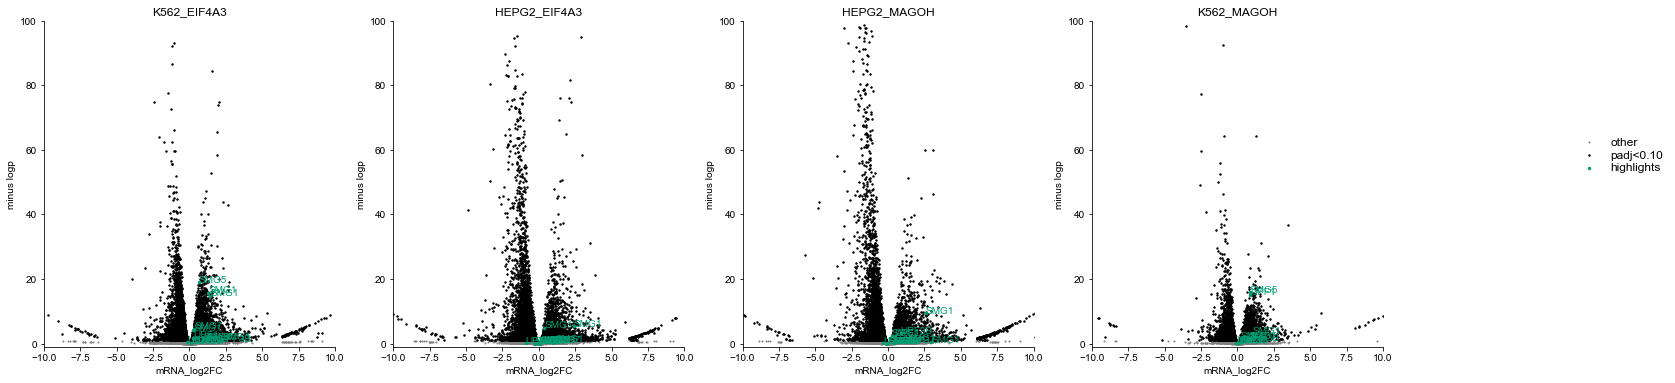

In [13]:
#first make volcano plots for major 3 comparisons - EDF1 vs WT and emetine treatments
dataset_names = ['K562_EIF4A3', 'HEPG2_EIF4A3', 'HEPG2_MAGOH', 'K562_MAGOH']
padj_cutoff = 0.1

x_var = 'mRNA_log2FC'
y_var = 'minus logp'

num_plots_wide = len(dataset_names)
num_plots_high = 1
fig = plt.figure(figsize=(6*num_plots_wide, 6*num_plots_high))
plot_index = 1

dataset_group = combined_deseq_results.groupby('dataset')

for dataset  in dataset_names:
    plot = fig.add_subplot(num_plots_high, num_plots_wide, plot_index)
    
    #pull out significant hits
    sig_dataset = dataset_group.get_group(dataset)
    sig_p = sig_dataset[sig_dataset['padj']<padj_cutoff]
    insig_p = sig_dataset[sig_dataset['padj']>padj_cutoff]
    #reporter = sig_dataset[sig_dataset['gene_name'].isin(['UGAC_reporter'])]
    highlight = sig_dataset[sig_dataset['gene name'].isin(['UPF3B', 'UPF1', 'SMG1', 'SMG5', 'SMG7'])]
    #make scatterplots
    insig_p.plot.scatter(x_var, y_var, color=gray, s=1, alpha=1, ax=plot, label='other')
    sig_p.plot.scatter(x_var, y_var, color=black, s=2, alpha=1, ax=plot, label='padj<%.2f' %(padj_cutoff))
    #reporter.plot.scatter(x_var, y_var, color=skyBlue, s=6, alpha=1, ax=plot, label='reporter')
    highlight.plot.scatter(x_var, y_var, color=bluishGreen, s=6, alpha=1, ax=plot, label='highlights')
    
    
    #label most significant hits
    #top_hits = sig_p[sig_p['log2FC_TE_final']>0]
    #top_hits = sig_p
    #top_hits = top_hits[~top_hits['gene_name'].isin(highlight['gene_name'])].sort_values(by=['pvalue.adjust'])[:5]
    #texts = []
    #for x, y, s in zip(top_hits[x_var], top_hits[y_var], top_hits['gene_name']):
    #    texts.append(plot.text(x, y, s))
    #    adjust_text(texts, only_move={'points':'y', 'text':'y'})
    top_hits = highlight
    texts = []
    for x, y, s in zip(top_hits[x_var], top_hits[y_var], top_hits['gene name']):
        texts.append(plot.text(x, y, s, color=bluishGreen))
        #adjust_text(texts, only_move={'points':'y', 'text':'y'})
    
    #adjust axes
    plot.set_title(dataset)
    plot.set_xlabel(x_var)
    plot.set_ylabel(y_var)
    #plot.set_xscale('log', basex=2)
    #plot.set_yscale('log', basey=2)
    plot.set_ylim(-1, 100)
    plot.set_xlim(-10, 10)
    plot.spines['right'].set_visible(False)
    plot.spines['top'].set_visible(False)
    #plot.set_aspect('equal')
    plot.get_legend().remove()
    plot_index+=1

lg=plot.legend(prop={'size':12}, labelspacing=0.2, bbox_to_anchor=(2,0.5), loc="lower right")
lg.draw_frame(False)
#plt.tight_layout()
plt.savefig('20201118_EJC_volcano_uplabel.pdf', transparent='True', format='pdf', bbox_inches='tight')
plt.savefig('20201118_EJC_volcano_uplabel.png', transparent='True', format='png', bbox_inches='tight')

## break out NMD targets with uORFs

In [15]:
def convertFastaToDict(fastaFile):
    '''
    converts a fasta file to a dict of {sequenceName:sequence}
    can take extra files in * args
    '''
    if isinstance(fastaFile, list):
        files = fastaFile
    else:
        files = [fastaFile]
    currentName = None
    currentSequence = None
    seqDict = {}
    seqInfo = {}
    for currentFile in files:
        if currentFile.endswith('.gz'):
            f = gzip.open(currentFile)
        else:
            f = open(currentFile)
        for line in f:
            if not line.strip() == '' and not line.startswith('#'):  # ignore empty lines and commented out lines
                if line.startswith('>'):  # > marks the start of a new sequence
                    if not currentName == None:  # after we've reached the firtst > line, we know what the sequence corresponds to
                        tx_id = currentName.split('|')[0]
                        seqDict[tx_id] = currentSequence
                        seqInfo[tx_id] = currentName
                    currentName = line.strip()[1:].split()[0]  # i've noticed the gencode names have extraneous numbering after some whitespace. This doens't match the GTF files, so I'm removing it.
                    currentSequence = ''
                else:
                    currentSequence += line.strip()
        f.close()
        tx_id = currentName.split('|')[0]
        seqDict[tx_id] = currentSequence
        seqInfo[tx_id] = currentName
    return seqDict, seqInfo
transcript_seqs, tx_info = convertFastaToDict('../../8.019_profiling_analysis/annotations/gencode.v34.pBZ105.pc_transcripts.fa')

In [16]:
tx_info

{'ENST00000394576.3': 'ENST00000394576.3|ENSG00000081853.15|OTTHUMG00000163679.4|OTTHUMT00000374738.2|PCDHGA2-201|PCDHGA2|4813|UTR5:1-212|CDS:213-3011|UTR3:3012-4813|',
 'ENST00000456402.5': 'ENST00000456402.5|ENSG00000168032.10|OTTHUMG00000131390.7|OTTHUMT00000343097.2|ENTPD3-204|ENTPD3|1749|UTR5:1-159|CDS:160-1749|',
 'ENST00000444547.6': 'ENST00000444547.6|ENSG00000116698.21|OTTHUMG00000035221.9|OTTHUMT00000358514.1|SMG7-206|SMG7|580|UTR5:1-119|CDS:120-341|UTR3:342-580|',
 'ENST00000249923.7': 'ENST00000249923.7|ENSG00000129083.12|OTTHUMG00000165824.2|OTTHUMT00000386410.1|COPB1-201|COPB1|3481|UTR5:1-301|CDS:302-3163|UTR3:3164-3481|',
 'ENST00000592202.5': 'ENST00000592202.5|ENSG00000126254.12|OTTHUMG00000182063.3|OTTHUMT00000459059.1|RBM42-206|RBM42|1469|UTR5:1-87|CDS:88-1368|UTR3:1369-1469|',
 'ENST00000375494.3': 'ENST00000375494.3|ENSG00000186190.7|OTTHUMG00000032234.2|OTTHUMT00000078654.2|BPIFB3-201|BPIFB3|1454|CDS:1-1431|UTR3:1432-1454|',
 'ENST00000421200.1': 'ENST00000421200.

In [17]:
def extract_3UTR_length(x):
    info_parts = tx_info[x].split('|')
    for info_part in info_parts:
        if info_part.startswith('UTR3'):
            UTR_positions = [int(pos) for pos in info_part.split(':')[1].split('-')]
            UTR_length = (UTR_positions[1] - UTR_positions[0])+1
    try:
        return UTR_length
    except:
        return 0
    
def extract_5UTR_length(x):
    info_parts = tx_info[x].split('|')
    for info_part in info_parts:
        if info_part.startswith('UTR5'):
            UTR_positions = [int(pos) for pos in info_part.split(':')[1].split('-')]
            UTR_length = (UTR_positions[1] - UTR_positions[0])+1
    try:
        return UTR_length
    except:
        return 0

def apply_3UTR_length_bins(x):
    #bins are inclusive. x should be an integer
    length_bins = [(0,124), (125, 379), (380, 869), (870, 1980), (1981, 26002) ]
    for length_bin in length_bins:
        if x >= length_bin[0] and x <= length_bin[1]:
            return ('%d-%d nt' % (length_bin[0], length_bin[1]))
        
colombo_p_values['3UTR length'] = colombo_p_values['tx_id'].apply(extract_3UTR_length)
colombo_p_values['5UTR length'] = colombo_p_values['tx_id'].apply(extract_5UTR_length)
colombo_p_values['length bin'] = colombo_p_values['3UTR length'].apply(apply_3UTR_length_bins)

In [18]:
GENETIC_CODE = {
    'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
    'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
    'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
    'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
    'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
    'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
    'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
    'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
    'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
    'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
    'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
    'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
    'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
    'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
    'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
    'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W',
}

def get_uORF_status(transcript, UTR5_length):
    """
    Defined as an AUG upstream of the main start codon, that either terminates supstream of the start,
    or is out of frame with the main start codon
    """
    transcript_seq = transcript_seqs[transcript].upper()
    UTR_seq = transcript_seq[:UTR5_length]
    
    for utr_position in range(UTR5_length):
        if UTR_seq[utr_position:utr_position+3] == 'ATG':
            #if this start codon is out of frame with the main ORF, it's a uORF.
            if not (utr_position%3 == UTR5_length%3):
                return True
            else:
                #if it is in frame, check if it terminates upstream of the stop
                for uORF_position in range(utr_position, UTR5_length, 3):
                    codon = UTR_seq[uORF_position:uORF_position+3]
                    if GENETIC_CODE[codon] == '_':
                        return True
    return False

colombo_p_values['has_uORF'] = colombo_p_values.apply(lambda row: get_uORF_status(row['tx_id'], row['5UTR length']), axis=1)

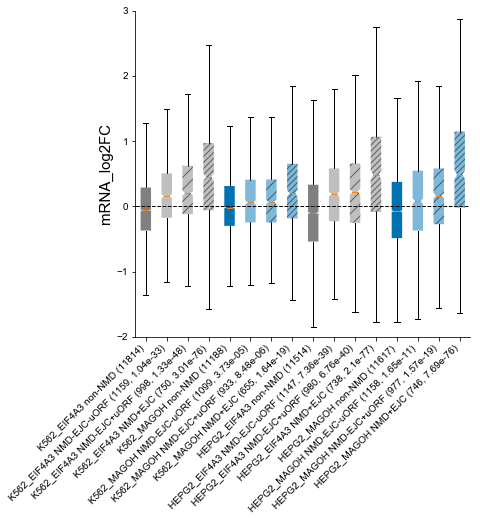

In [19]:
#plot fold changes for each dataset in same plot, single EJC cutoff, groups do not overlap
variables_to_plot = ['mRNA_log2FC']
p = .05
datasets = ['K562_EIF4A3',  'K562_MAGOH', 'HEPG2_EIF4A3', 'HEPG2_MAGOH']
#collect transcripts common to all datasets
dataset_group = combined_deseq_results.groupby('dataset')
dataset = datasets[0]
df = dataset_group.get_group(dataset)
tx_overlap = set(df.dropna()['tx_id'])
for dataset in datasets:
    df = dataset_group.get_group(dataset)
    tx_overlap = tx_overlap.intersection(set(df.dropna()['tx_id']))

plot_colors = [gray, blue, reddishPurple, vermillion]


plot_index = 1
num_plots_wide = len(variables_to_plot)
num_plots_high = 1
fig = plt.figure(figsize=(6*num_plots_wide, 6*num_plots_high))

colombo_nmd_targets = colombo_p_values[colombo_p_values['meta_meta']<p]
plots = []
for variable_to_plot in variables_to_plot:
    color_index = 0
    plot = fig.add_subplot(num_plots_high, num_plots_wide, plot_index)
    plots.append(plot)
    box_data = []
    box_colors = []
    box_labels = []
    reporter_data = []
    for dataset in datasets:  
        
        #first assemble dataframes for 3 groups: non-NMD targets, colombo NMD targets, colombo NMD targets with EJC
        df = dataset_group.get_group(dataset)
        #df = df[df['tx_id'].isin(tx_overlap)] #only use transcripts with data in all datasets
        all_colombo_tx = colombo_p_values[colombo_p_values['meta_meta']<=1]
        uORF = colombo_p_values[colombo_p_values['has_uORF']]
        
        all_df = df[df['tx_id'].isin(all_colombo_tx['tx_id'])]
        #filter for NMD hits by p value
        nmd_colombo_tx = colombo_p_values[colombo_p_values['meta_meta']<=p]
        nmd_df = all_df[all_df['tx_id'].isin(nmd_colombo_tx['tx_id'])]
        #filter for colombo targets with EJC
        ejc_tx = colombo_p_values[colombo_p_values['GENCODE nmd annotation']]
        nmd_EJC_df = nmd_df[nmd_df['tx_id'].isin(ejc_tx['tx_id'])]
        #remove NMD targets from "All":
        non_nmd_df = all_df[~all_df['tx_id'].isin(nmd_df['tx_id'])]
        #remove tx with EJC from non-EJC NMD df
        no_ejc_nmd_df = nmd_df[~nmd_df['tx_id'].isin(nmd_EJC_df['tx_id'])]
        no_ejc_no_uORF_nmd_df = no_ejc_nmd_df[~no_ejc_nmd_df['tx_id'].isin(uORF['tx_id'])]
        no_ejc_uORF_nmd_df = no_ejc_nmd_df[no_ejc_nmd_df['tx_id'].isin(uORF['tx_id'])]
        
        #append boxplot data and p values to lists
        box_data.append(non_nmd_df[variable_to_plot])
        box_colors.append(plot_colors[color_index%2])
        box_labels.append('%s non-NMD (%d)' %(dataset, len(non_nmd_df[variable_to_plot].dropna())))
                
        mwu, mwp = stats.mannwhitneyu(non_nmd_df[variable_to_plot].dropna(), no_ejc_no_uORF_nmd_df[variable_to_plot].dropna(), alternative='two-sided')
        box_data.append(no_ejc_no_uORF_nmd_df[variable_to_plot].dropna())
        box_colors.append(plot_colors[color_index%2])
        box_labels.append('%s NMD-EJC-uORF (%d, %.3g)' %(dataset, len(no_ejc_no_uORF_nmd_df[variable_to_plot].dropna()), mwp))
        
        mwu, mwp = stats.mannwhitneyu(non_nmd_df[variable_to_plot].dropna(), no_ejc_uORF_nmd_df[variable_to_plot].dropna(), alternative='two-sided')
        box_data.append(no_ejc_uORF_nmd_df[variable_to_plot].dropna())
        box_colors.append(plot_colors[color_index%2])
        box_labels.append('%s NMD-EJC+uORF (%d, %.3g)' %(dataset, len(no_ejc_uORF_nmd_df[variable_to_plot].dropna()), mwp))
        
        mwu, mwp = stats.mannwhitneyu(non_nmd_df[variable_to_plot].dropna(), nmd_EJC_df[variable_to_plot].dropna(), alternative='two-sided')
        box_data.append(nmd_EJC_df[variable_to_plot].dropna())
        box_colors.append(plot_colors[color_index%2])
        box_labels.append('%s NMD+EJC (%d, %.3g)' %(dataset, len(nmd_EJC_df[variable_to_plot].dropna()), mwp))
        color_index+=1
        
    bp = plot.boxplot(box_data, labels=box_labels, patch_artist=True, showfliers=False, notch=True,)
    
    # fill with colors
    i = 0
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set(linewidth=0)
        if i%4 > 0:
            patch.set_alpha(0.5)
        if i%4 == 2:
            patch.set_hatch('//')
        if i%4 == 3:
            patch.set_hatch('////')
        i += 1
    #draw line at median
    for i in range(0, 4*len(datasets), 4):
        mean = np.median(box_data[i])
        #plot.hlines(mean, i+0.75, i+3.25, linestyles='dashed', colors=black, linewidth=1, zorder=10)
    plot.hlines(0, 0, 4*len(datasets)+1, linestyles='dashed', colors=black, linewidth=1, zorder=10)
    #plot.set_xlabel(variable_to_plot)
    plot.set_ylabel(variable_to_plot, fontsize=15)
    #plot.set_title('NMD p = %.3g' %(p))
    #plot.set_ylim(0, 1.01)
    #if variable_to_plot == 'log2FC_TE_final':
    #    plot.set_xlim(-2, 2)
    #else:
    #plot.set_xlim(-1, 1)
    plot.spines['right'].set_visible(False)
    plot.spines['top'].set_visible(False)
    plt.xticks(rotation=45, ha='right')
    plot_index += 1
    #lg=plot.legend(loc=4,prop={'size':12}, labelspacing=0.2)
    #lg.draw_frame(False)
plots[0].set_ylim(-2, 3)
#plots[1].set_ylim(-2, 6)
#plots[2].set_ylim(-2, 3)

plt.subplots_adjust(wspace = 0.3)
#plt.tight_layout()
plt.savefig('E.8.027_20201215_uORF_EJC_knockdowns_RNA_change.pdf', transparent='True', format='pdf', bbox_inches='tight')